In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import matplotlib.pyplot as plt

In [10]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings

from scipy.stats import mannwhitneyu
def perform_mann_whitney_u_test(data1, data2):
    """Perform Mann-Whitney U test between two groups of data."""
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value

In [12]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []
waiting_times_data = {rho: {1: [], 2: [], 4: []} for rho in RHO}

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })
        # 添加等待时间数据
        for wt in sim_data:
            waiting_times_data[rho][num_servers].extend(wt)

# 比较 n=2 与 n=1，n=4 与 n=2 的平均等待时间
for rho in RHO:
    u_statistic, p_value_2_vs_1 = perform_mann_whitney_u_test(waiting_times_data[rho][2], waiting_times_data[rho][1])
    u_statistic, p_value_4_vs_2 = perform_mann_whitney_u_test(waiting_times_data[rho][4], waiting_times_data[rho][2])
    print(f"ρ={rho}: n=2 vs n=1, p-value = {p_value_2_vs_1}; n=4 vs n=2, p-value = {p_value_4_vs_2}")

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


ρ=0.1: n=2 vs n=1, p-value = 0.003622882970159448; n=4 vs n=2, p-value = 0.4961822310074797
ρ=0.5: n=2 vs n=1, p-value = 7.459213567608938e-77; n=4 vs n=2, p-value = 5.0313342096753094e-55
ρ=0.9: n=2 vs n=1, p-value = 4.8966279232758125e-93; n=4 vs n=2, p-value = 0.0
ρ=0.99: n=2 vs n=1, p-value = 2.022887440301051e-86; n=4 vs n=2, p-value = 8.195176068815565e-106
    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.045365   
1             2  0.10          0.961578   
2             4  0.10          0.985196   
3             1  0.50          1.910012   
4             2  0.50          1.274404   
5             4  0.50          1.066125   
6             1  0.90          5.152094   
7             2  0.90          3.853804   
8             4  0.90          2.509921   
9             1  0.99          6.700102   
10            2  0.99          4.940992   
11            4  0.99          4.041378   

                                     all_waiting_time  \
0   [[1.934909438

In [3]:
# 画ρ影响平均等待时间的图

def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title('Comparison of Average Waiting Time by System Load')
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


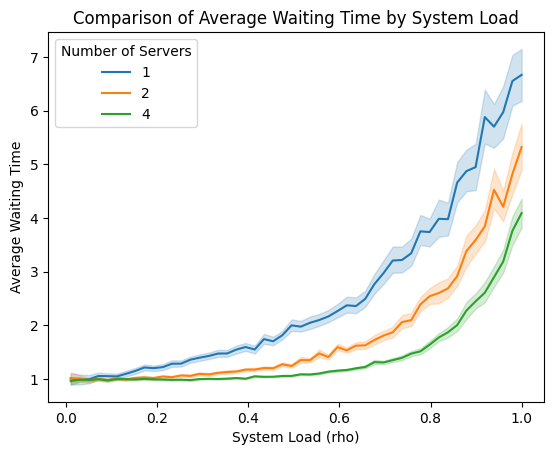

In [37]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


In [6]:
print(all_sim_data[0]['all_waiting_time'][1])

[0.9903755735100361, 1.1812221245485937, 2.936016771134259, 3.0717678340178693, 0.9064500500488091, 0.38684183855715304, 0.056968146416551235, 0.17935033430504177, 2.8663025504752966, 3.3023592291246473, 1.1441829709229978, 0.5156078081541722, 1.1273270080098854, 0.03801652047151549]


In [4]:
# 绘制直方图或密度图
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
#     print(len(all_sim_data))
#     sns.histplot(all_sim_data, kde=True, element='step', stat='density', bins=200)
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    

# 绘制叠加的直方图或密度图
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    # 将模拟结果中的所有等待时间整理到一个列表中
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


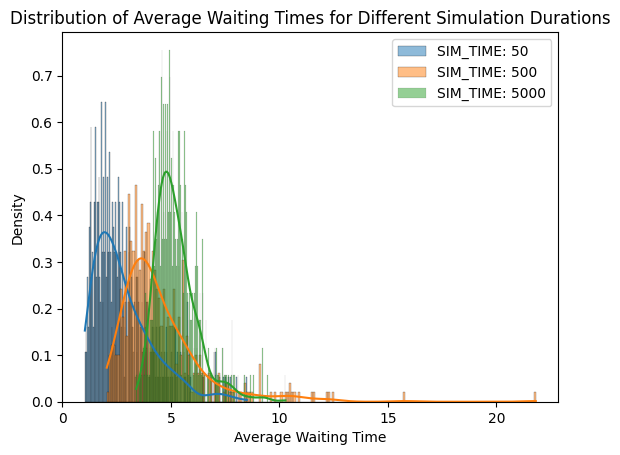

In [8]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = 500  # 模拟次数
SIM_TIMES = [50, 500, 5000]  # 不同的模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIM_TIME: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


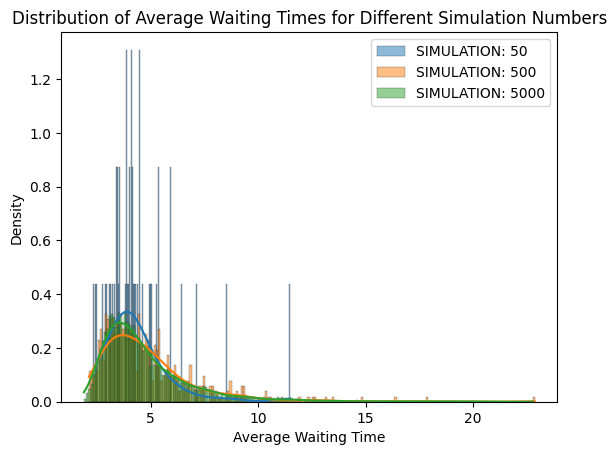

In [7]:
# 定义模拟参数
num_servers = 2  # 服务器数量
rho = 0.9  # 系统负载
MU = 1  # 服务率
SIMULATIONS = [50, 500, 5000]  # 不同的模拟时长
SIM_TIME = 500  # 模拟时长

# 运行模拟并收集结果
simulation_results = []
for SIMULATION in SIMULATIONS:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATION)
    simulation_results.append(avg_waitings)

# 定义标签
labels = [f'SIMULATION: {SIMULATION}' for SIMULATION in SIMULATIONS]

# 绘制结果
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Numbers", labels)


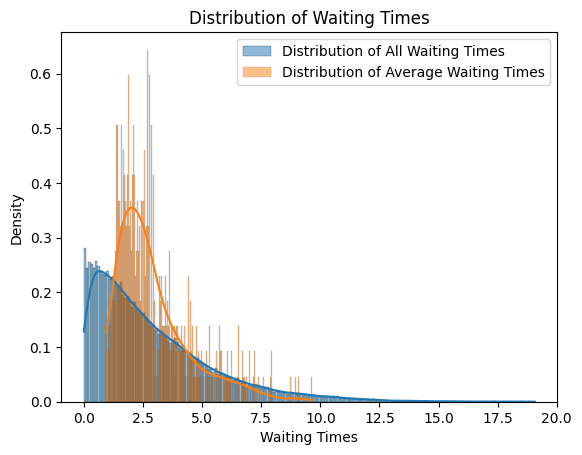

In [9]:
# Simulation parameters
num_servers = 2
rho = 0.9  # System load
MU = 1  # Service rate
SIM_TIME = 50  # Simulation duration
SIMULATIONS = 500  # Number of simulations


sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual

all_waiting_times = []
for data in sim_data:
    all_waiting_times.extend(data)

# plt_distribution(all_waiting_times, 'Distribution of All Waiting Times')
# plt_distribution(avg_waitings, 'Distribution of Average Waiting Times')
group_data = [all_waiting_times, avg_waitings]
labels = ['Distribution of All Waiting Times', 'Distribution of Average Waiting Times']
plt_distribution_group(group_data, "Distribution of Waiting Times", labels, "Waiting Times")

In [16]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney_u_test(data1, data2):
    """Perform Mann-Whitney U test between two groups of data."""
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value


In [17]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 30
MU = 1
rho = 0.99

# 运行模拟并收集数据
# avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
# avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

_, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
_, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

# print(avg_waitings_1_server)
# print(avg_waitings_2_servers)
# print(avg_waitings_4_servers)

# 进行Mann-Whitney U检验
u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value:", p_4_vs_2)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value:", p_2_vs_1)


Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 429.0 P-Value: 0.3809141729677374
2 servers vs 1 server: U-Statistic: 376.0 P-Value: 0.13859459488652393


In [18]:
# 模拟参数
SIM_TIME = 50
SIMULATIONS = 120
MU = 1
rho = 0.5

p_4_vs_2_list = []
p_2_vs_1_list = []
for _ in range(10):
    # 运行模拟并收集数据
    # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
    _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

    # print(avg_waitings_1_server)
    # print(avg_waitings_2_servers)
    # print(avg_waitings_4_servers)

    # 进行Mann-Whitney U检验
    u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
    u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
    
    p_4_vs_2_list.append(p_4_vs_2)
    p_2_vs_1_list.append(p_2_vs_1)
    
p_4_vs_2_mean = np.mean(p_4_vs_2_list)
p_2_vs_1_mean = np.mean(p_2_vs_1_list)

print("Mann-Whitney U Test Results:")
print("4 servers vs 2 servers: U-Statistic:", u_stat_4_vs_2, "P-Value-Mean:", p_4_vs_2_mean)
print("2 servers vs 1 server: U-Statistic:", u_stat_2_vs_1, "P-Value-Mean:", p_2_vs_1_mean)





Mann-Whitney U Test Results:
4 servers vs 2 servers: U-Statistic: 4347.0 P-Value-Mean: 8.78756802499116e-06
2 servers vs 1 server: U-Statistic: 4435.0 P-Value-Mean: 3.158134004258745e-08


############  rho = 0.5
SIMULATIONS = 20
0.03359979775202521 0.018767878221097933
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.014497816867197037 0.027596614949674303
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.05373295233898094 0.02033297079352518
SIMULATIONS = 21
0.014795288203736694 0.03100062175079052
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.03685074365306322 0.01151293848717956
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.010048742084754253 0.04298693030580896
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.045081966553640954 0.06695590830668001
SIMULATIONS = 21
0.02966268898400561 0.07833382009176898
SIMULATIONS = 22
0.018121342507099736 0.0891594089663251
SIMULATIONS = 23
0.06313627241318173 0.011856526157102048
SIMULATIONS = 24
0.028162089067360545 0.033380263643846324
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.018204848539387076 0.10971855828059769
SIMULATIONS = 21
0.03426712404881006 0.050326615

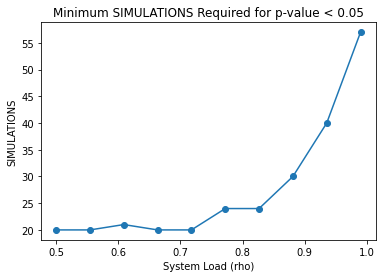

In [19]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (rho)")
plt.ylabel("SIMULATIONS")
plt.show()


############  rho = 0.5
SIMULATIONS = 20
0.05596037675894031 0.043945766233096185
SIMULATIONS = 21
0.0598558933630615 0.07927635102631926
SIMULATIONS = 22
0.027212230362563865 0.02654267059642267
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.0446368436987851 0.030549943181571317
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.01893196301986455 0.03858983013448532
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.018735879766054963 0.03979224440764166
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.017610101654022374 0.05471891745907511
SIMULATIONS = 21
0.018502952851313956 0.043482952767477295
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.03823292465360487 0.025270975990886152
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.04166806810012226 0.07055458340124685
SIMULATIONS = 21
0.01895133456347116 0.08797133239746249
SIMULATIONS = 22
0.06036844485904476 0.1045685781667924
SIMULATIONS = 23
0.015684777338198393 0.0645859279387

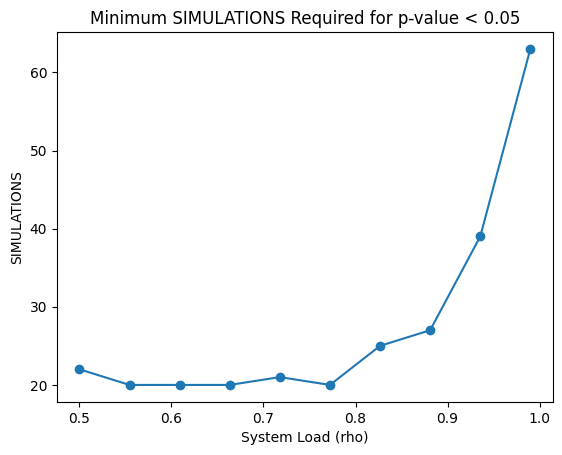

In [302]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (rho)")
plt.ylabel("SIMULATIONS")
plt.show()


############  rho = 0.5
SIMULATIONS = 20
0.05364113485442523 0.045408686284843555
SIMULATIONS = 21
0.06910693652802136 0.04555847091533299
SIMULATIONS = 22
0.04269661683128236 0.028035650479993086
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.0378890159248898 0.004717603769870889
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.007713235868899179 0.0581414180885237
SIMULATIONS = 21
0.010781966206564294 0.037655323501634495
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.0261484041508813 0.014201768765245098
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.04188631290135556 0.030721072382587488
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.035023070120220316 0.057016404845468306
SIMULATIONS = 21
0.030437901331286023 0.04895384041513812
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.058909764299499436 0.11243578617004064
SIMULATIONS = 21
0.04323454066605285 0.06693602540408455
SIMULATIONS = 22
0.046271898546379774 0.056171403

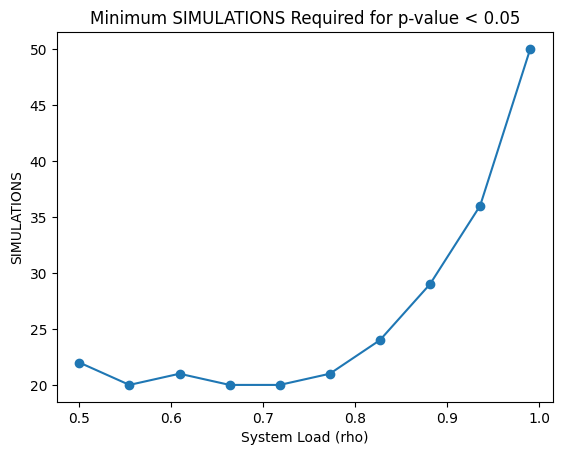

In [41]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # 运行模拟并收集数据
        # avg_waitings_1_server, _ = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_2_servers, _ = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        # avg_waitings_4_servers, _ = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # print(avg_waitings_1_server)
        # print(avg_waitings_2_servers)
        # print(avg_waitings_4_servers)

        # 进行Mann-Whitney U检验
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)
#         print(p_4_vs_2, p_2_vs_1)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# 绘制图表
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (rho)")
plt.ylabel("SIMULATIONS")
plt.show()


In [15]:
# 初始化模拟环境和顾客到达过程
def setup_MDn(env, num_servers, servicetime, Lambda, waiting_times):
    # 生成服务器资源
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """服务过程使用指数分布的服务时间"""
        yield env.timeout(servicetime)

    def customer(name):
        """顾客到达和服务过程"""
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # 记录每个顾客的等待时间
            waiting_times.append(waiting_time)
    
    # 生成初始顾客
    env.process(customer('Customer 0'))

    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# 运行模拟函数
def run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # 到达率
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_MDn(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [21]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.042487   
1             2  0.10          1.008738   
2             4  0.10          1.000129   
3             1  0.50          1.480368   
4             2  0.50          1.184127   
5             4  0.50          1.051207   
6             1  0.90          3.658318   
7             2  0.90          2.567612   
8             4  0.90          1.768218   
9             1  0.99          5.522712   
10            2  0.99          3.886561   
11            4  0.99          3.141115   

                                     all_waiting_time  \
0   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1....   
1   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2   [[1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0,...   
3   [[1.0, 1.0, 1.97566206400422, 1.0, 1.0, 1.0, 1...   
4   [[1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0,...   
5   [[1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0,...   
6   [[1.0, 1.512998989231706, 2.270316669

In [18]:
# 画ρ影响平均等待时间的图

def run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)


def plot_data(df, title = "Comparison of Average Waiting Time by System Load"):
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title(title)
    plt.xlabel('System Load (rho)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()


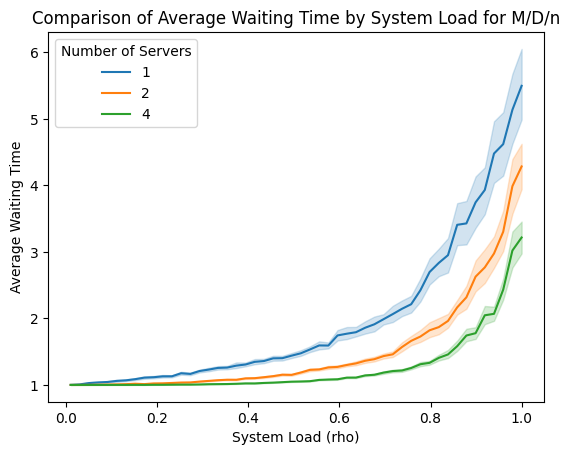

In [17]:
# 定义参数
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df, "Comparison of Average Waiting Time by System Load for M/D/n")


# Compare M/M/1 queue with shortest job first scheduling

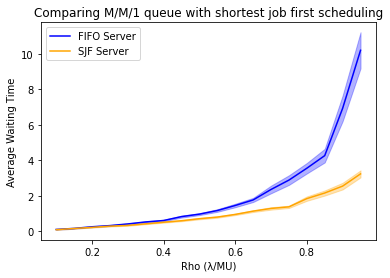

In [4]:
# 不同Rho（固定MU）的情况下，M/M/1和shortest job first scheduling的对比
# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(MU)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and pass it to job_generator
def run_simulation_sjfs(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation


# Parameters
MU = 1  # Fixed service rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging

# Prepare a range of rho values
rhos = np.arange(0.1, 1.0, 0.05)
results = []

for rho in rhos:
    lambda_val = rho * MU
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('Rho (λ/MU)')
plt.ylabel('Average Waiting Time')
plt.title('Comparing M/M/1 queue with shortest job first scheduling')
plt.legend()
plt.show()

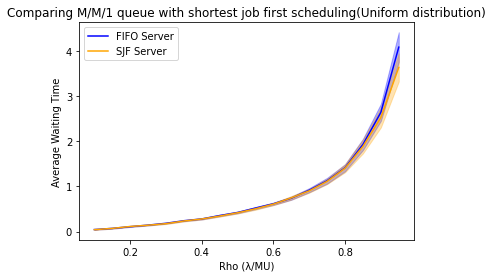

In [5]:
# 把job lengths改为稳定的分布会缩小M/M/1和shortest job first scheduling的差异
# Adjusted job_generator for consistent job lengths and lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.uniform(0.9, 1.0)  # Consistent job lengths
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation
def run_simulation_sjfs(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Parameters
MU = 1  # Fixed service rate (MU)
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
rhos = np.arange(0.1, 1.0, 0.05)  # Range of rho values

# Run the simulation
results = []
for rho in rhos:
    lambda_val = rho * MU  # Calculate lambda for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame and plot
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('Rho (λ/MU)')
plt.ylabel('Average Waiting Time')
plt.title('Comparing M/M/1 queue with shortest job first scheduling(Uniform distribution)')
plt.legend()
plt.show()

# Long tail distribution

In [20]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.75:  # 75%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余25%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [25]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          2.252954   
1             2  0.10          2.102027   
2             4  0.10          1.902934   
3             1  0.50         10.098640   
4             2  0.50          7.987795   
5             4  0.50          6.188601   
6             1  0.90         22.216599   
7             2  0.90         23.062152   
8             4  0.90         21.778517   
9             1  0.99         24.486246   
10            2  0.99         25.061766   
11            4  0.99         24.259665   

                                     all_waiting_time  \
0   [[1.7517133714844952, 0.38316547187736205, 1.3...   
1   [[0.9296260496756119, 3.4157163335299003, 0.40...   
2   [[1.5076033525754808, 0.2450453026134829, 0.36...   
3   [[0.5731821676683033, 0.5035914142639845, 0.48...   
4   [[0.4632225459793302, 1.5455718644639023, 1.55...   
5   [[0.19777792404663075, 0.037519453109724266, 0...   
6   [[2.150796247214884, 8.02931017113715

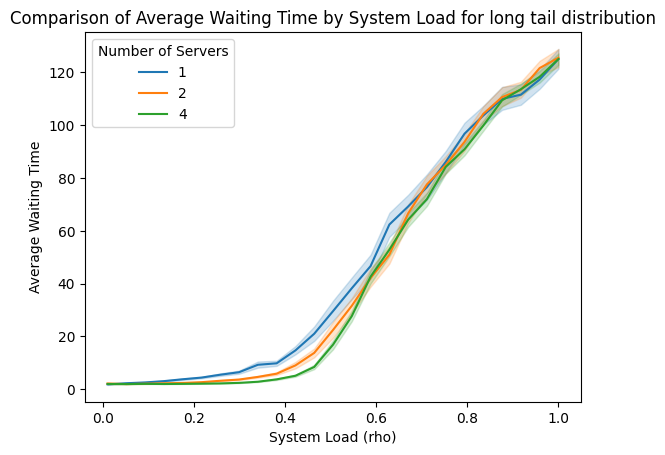

In [21]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df, "Comparison of Average Waiting Time by System Load for long tail distribution")


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


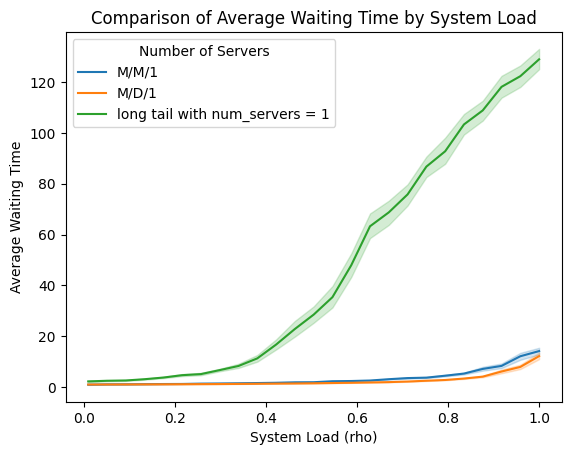

In [22]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1", "long tail with num_servers = 1"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


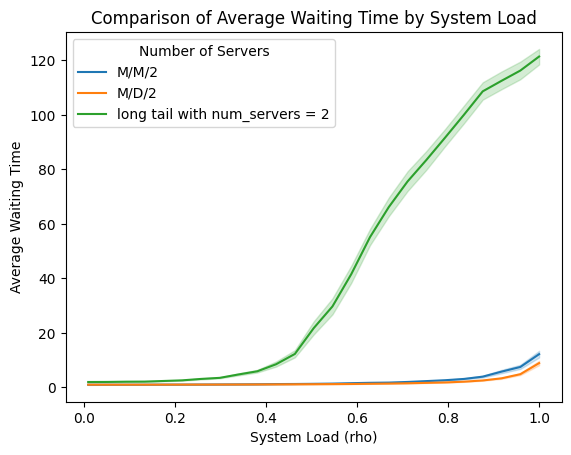

In [23]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


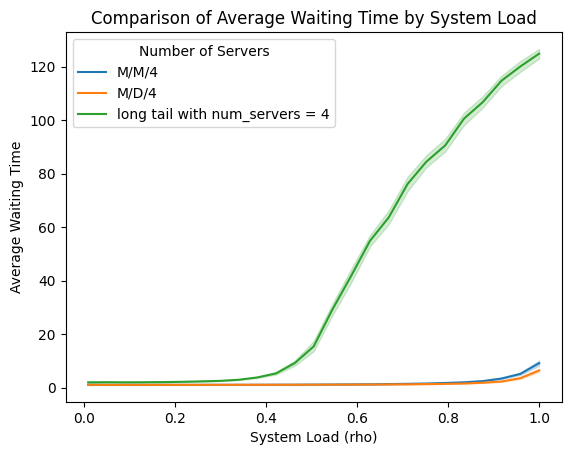

In [24]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "long tail with num_servers = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


# 改变long tail的分布为50%-50%

In [25]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.50:  # 50%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余50%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [26]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          4.196007   
1             2  0.10          3.112425   
2             4  0.10          2.979835   
3             1  0.50         20.302927   
4             2  0.50         18.247942   
5             4  0.50         18.963899   
6             1  0.90         30.453405   
7             2  0.90         30.771657   
8             4  0.90         32.264280   
9             1  0.99         33.251818   
10            2  0.99         32.390191   
11            4  0.99         32.917267   

                                     all_waiting_time  \
0   [[0.40034218295550517, 0.1539611999023549, 1.0...   
1   [[2.032681481851192, 1.5411394531996727, 0.770...   
2   [[0.745285405902897, 0.8875464820577896, 3.794...   
3   [[1.6233522785026775, 2.284072729061468, 2.669...   
4   [[0.1886722846630851, 2.919218767533086, 5.327...   
5   [[1.84220791812189, 1.4673835636936063, 3.2571...   
6   [[0.6195718286341235, 7.7144802788263

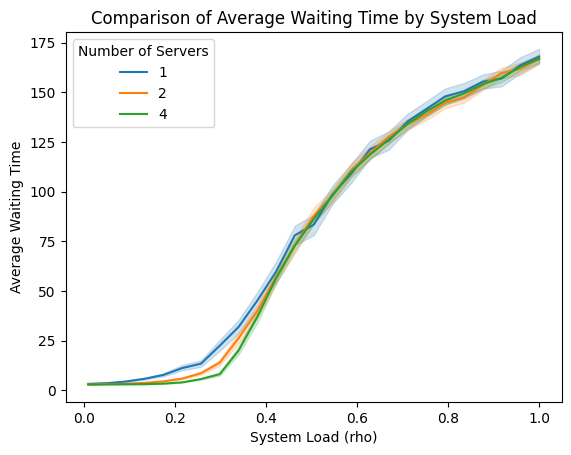

In [27]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


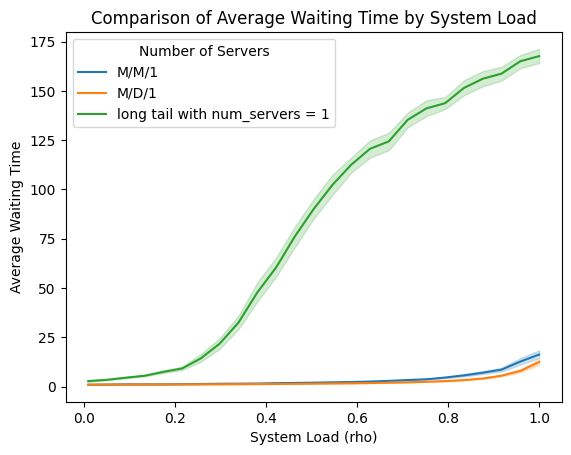

In [28]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1", "long tail with num_servers = 1"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


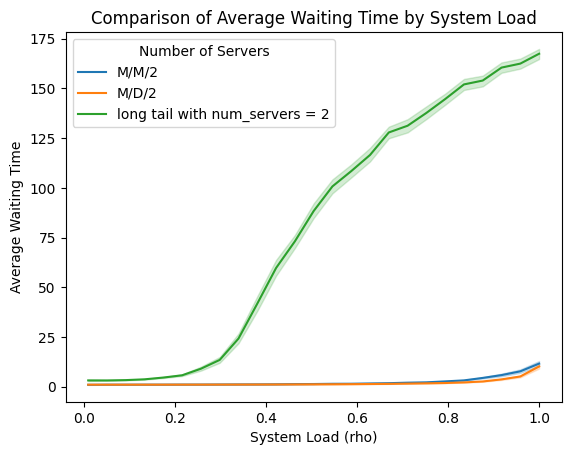

In [29]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


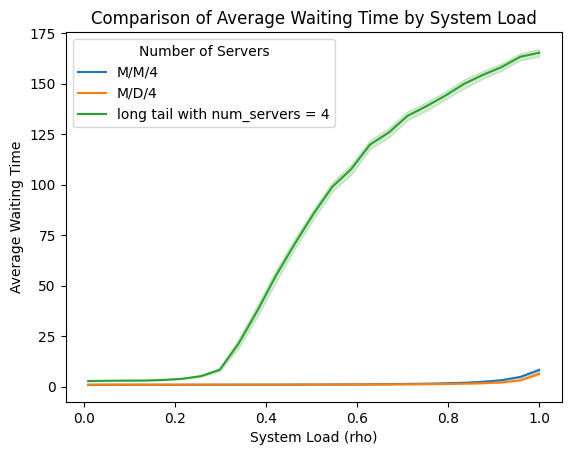

In [30]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "long tail with num_servers = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


# 改变Long tail的service time（分别为1和9）

In [31]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # 随机选择服务时间分布
        if np.random.rand() < 0.75:  # 75%的情况，使用平均服务时间为1.0的指数分布
            yield env.timeout(np.random.exponential(1.0))
        else:  # 剩余25%的情况，使用平均服务时间为5.0的指数分布
            yield env.timeout(np.random.exponential(9.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [32]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          3.718289   
1             2  0.10          3.472320   
2             4  0.10          2.613226   
3             1  0.50         18.793168   
4             2  0.50         17.035041   
5             4  0.50         16.883895   
6             1  0.90         29.961043   
7             2  0.90         29.671055   
8             4  0.90         30.303841   
9             1  0.99         33.165875   
10            2  0.99         31.934624   
11            4  0.99         29.958336   

                                     all_waiting_time  \
0   [[1.0639777106189947, 1.9804157628564845, 1.85...   
1   [[0.4650893412052399, 0.9906088494012417, 0.02...   
2   [[0.9993213105957861, 0.49444877326529024, 0.8...   
3   [[0.19409197666069022, 0.8923959442808819, 17....   
4   [[1.9720721011815427, 6.854651673972121, 2.573...   
5   [[0.4921209830231792, 1.6803095249024733, 0.29...   
6   [[1.8882029309314197, 2.0724892926414

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


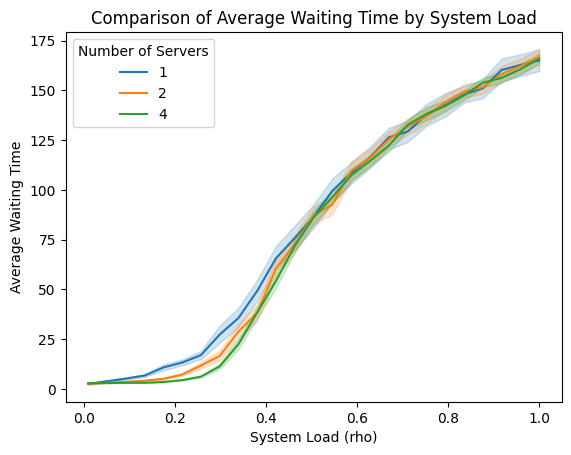

In [33]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # 比如说，服务器数量为1、2和4

# 运行模拟并收集结果
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


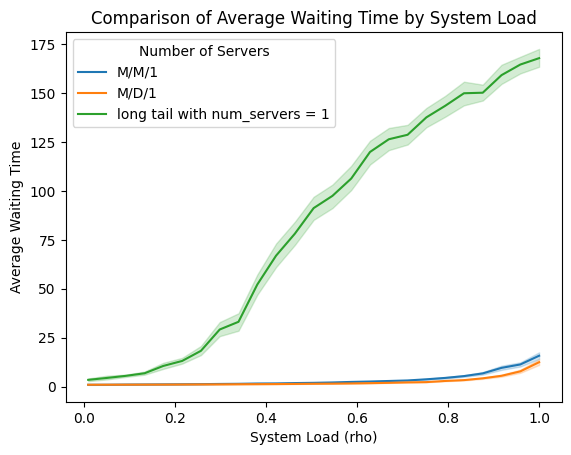

In [34]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/1", "M/D/1", "long tail with num_servers = 1"]  # 图片标签

simulation_results = []

num_servers = 1
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


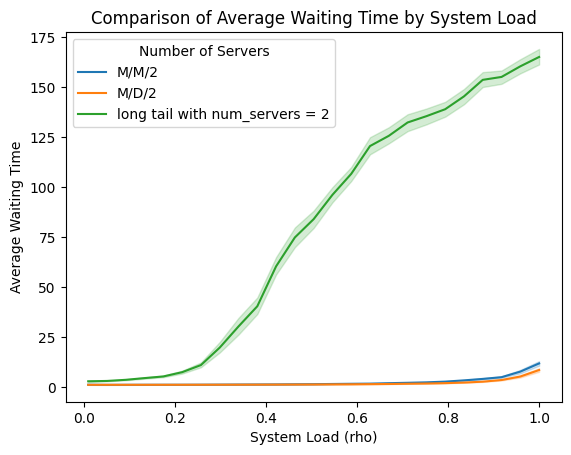

In [35]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/2", "M/D/2", "long tail with num_servers = 2"]  # 图片标签

simulation_results = []

num_servers = 2
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


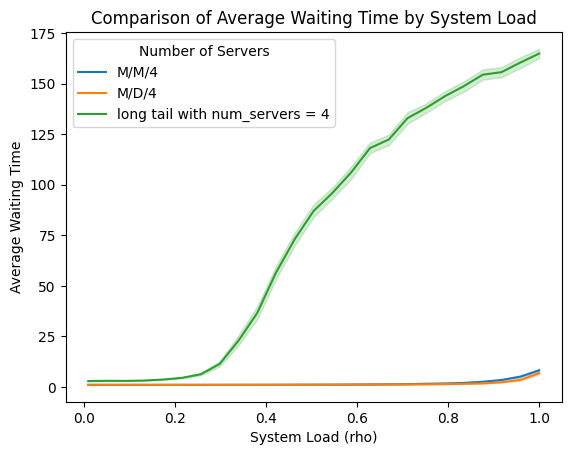

In [36]:


def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# 定义参数
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = ["M/M/4", "M/D/4", "long tail with num_servers = 4"]  # 图片标签

simulation_results = []

num_servers = 4
simulation_results.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results.append(run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))



# 运行模拟并收集结果
# simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# 准备数据
plot_df = prepare_plot_data(simulation_results, server_configs)

# 绘制数据
plot_data(plot_df)


### 不用的代码

In [ ]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

# 设置输出格式，以显示所有行和列
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 定义队列类
class Queue:
    def __init__(self, env, num_servers, servicetime):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.servicetime = servicetime

    def service(self, customer):
        """服务过程使用指数分布的服务时间"""
        yield self.env.timeout(np.random.exponential(self.servicetime))

# 定义顾客到达过程
def customer(env, name, qu):
    arrival_time = env.now
    with qu.server.request() as request:
        yield request
        yield env.process(qu.service(name))
        waiting_time = env.now - arrival_time
        # 记录每个顾客的等待时间
        qu.env.waiting_times.append(waiting_time)

# 初始化模拟环境和顾客到达过程
def setup(env, num_servers, servicetime, Lambda):
    queue = Queue(env, num_servers, servicetime)
    queue.env.waiting_times = []
    # 生成初始顾客
    env.process(customer(env, 'Customer 0', queue))
    # 持续生成顾客
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(env, f'Customer {env.now}', queue))

# 运行模拟函数
def run_simulation(num_servers, Lambda, servicetime, SIM_TIME, SIMULATIONS):
    data_sims = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        env.process(setup(env, num_servers, servicetime, Lambda))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(env.waiting_times)
        data_sims.append(avg_waiting)
    return data_sims

# 模拟参数
MU = 1  # the capacity of each of n equal servers
SIM_TIME = 100
SIMULATIONS = 100
SERVERS = [1, 2, 4]  # 服务器数量n
RHO = [0.5, 0.9, 0.99]  # the system load, RHO = Lambda / (MU * n)

# 存储所有模拟的结果
all_sim_data = []

# 对每个服务器数量n和系统负载ρ运行模拟
for num_servers in SERVERS:
    for rho in RHO:
        Lambda = rho * (MU * num_servers)  # the arrival rate into the system as a whole
        sim_data = run_simulation(num_servers, Lambda, 1/MU, SIM_TIME, SIMULATIONS)
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(sim_data),
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(sim_data), scale=stats.sem(sim_data))
        })

# 将结果转换为DataFrame并保存为CSV文件
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)
